# 🛒 Walmart Retail Analysis - Kaggle Dataset (WIP)

Completed by: Christine (TangoMango223) <br>
Source: https://www.kaggle.com/datasets/yasserh/walmart-dataset

In [241]:
# Import statements:

# For Data Analysis, EDA:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from tabulate import tabulate
import statsmodels.api as sm
from scipy.stats import boxcox, norm, probplot
from scipy.stats.mstats import winsorize
from scipy.special import inv_boxcox

# # Secret API Key
# import os
# # from dotenv import load_dotenv

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# External Libraries
import xgboost as xgb
import lightgbm as lgb
import shap

# NLP:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import re

# Unverified SSL to allow importing dataset from Github:
import ssl

# ssl._create_default_https_context = ssl._create_unverified_context

In [183]:
# Read in to Pandas csv:
df = pd.read_csv('https://raw.githubusercontent.com/TangoMango223/walmart_analysis/master/Walmart.csv')

# Exploratory Data Analysis (EDA)

In [184]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [185]:
# We don't appear to have any missing data which is good.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [186]:
# Let's conduct univariate analysis...
# Our goal is to predict weekly sales...

In [187]:
# Check if stores is unique - it's not
df["Store"].is_unique

False

In [188]:
# Divide between numerical and categorical variables.
numerical_cols = df.select_dtypes(include = 'number');

In [189]:
# The only one not number is date-time, which we will deal with later.

In [190]:
# Look at the stores...

def numerical_var(df, col):
    # Function to quickly look into the numerical variables
    sns.boxplot(data = df, x = col)
    plt.title(f"Boxplot of {col}")
    plt.show()
    
    # Look at histogram as well:
    sns.histplot(data = df, x = col)
    plt.title(f"Histogram of {col}")
    plt.show()
    

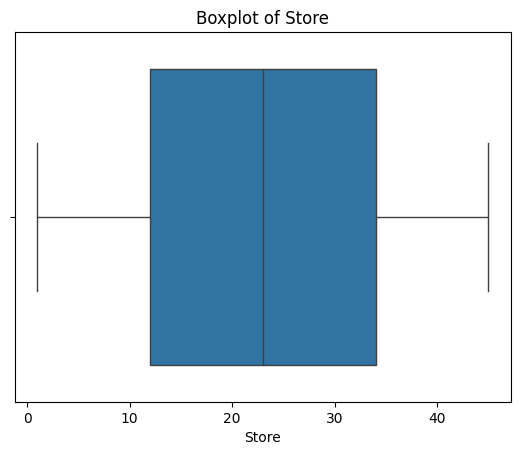

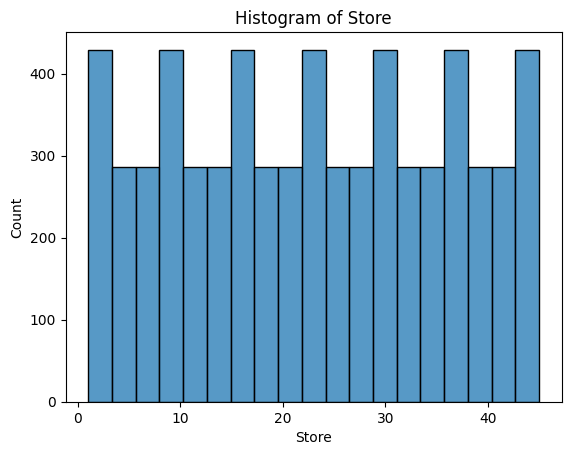

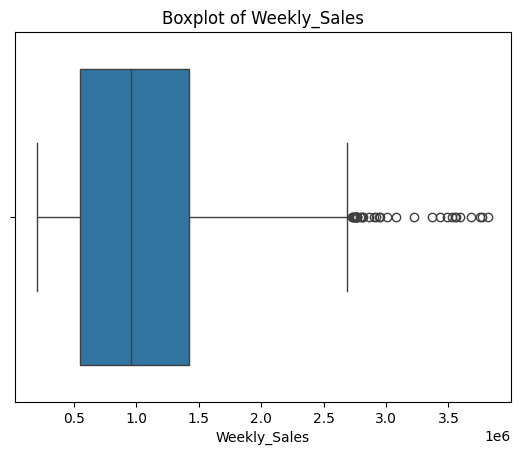

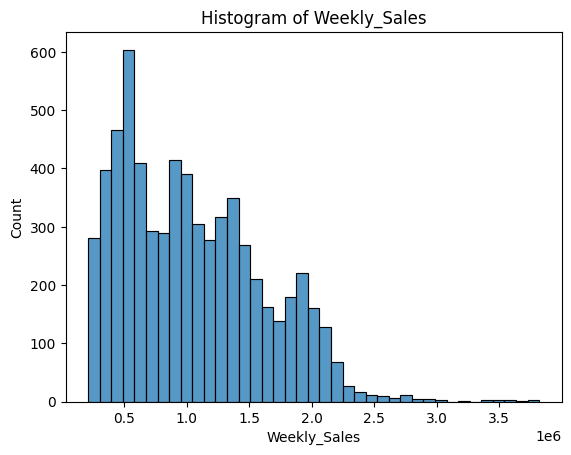

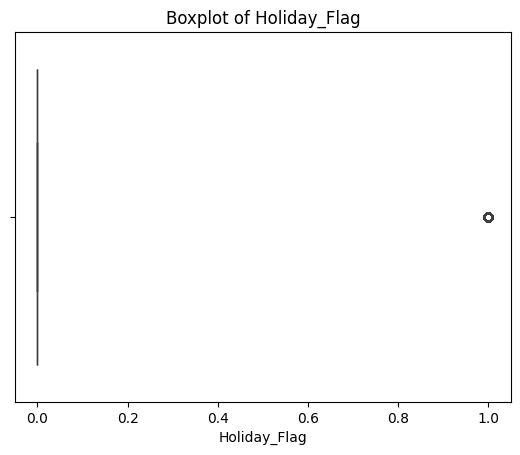

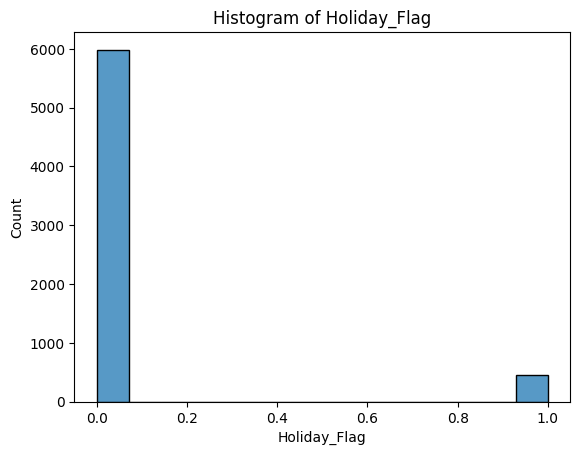

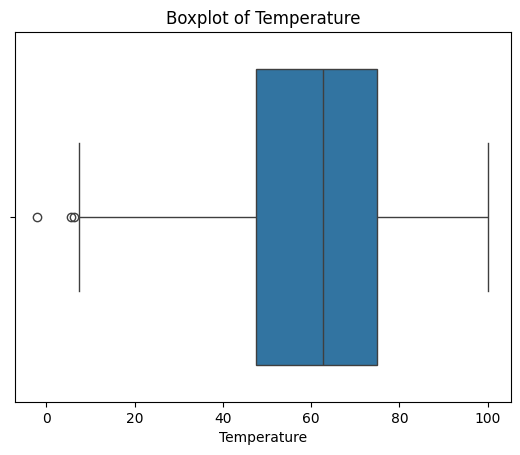

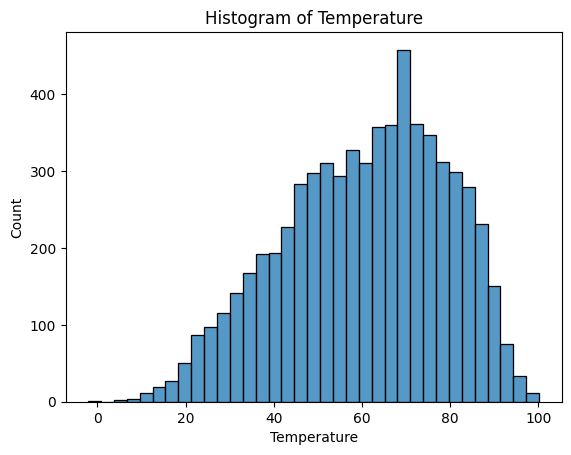

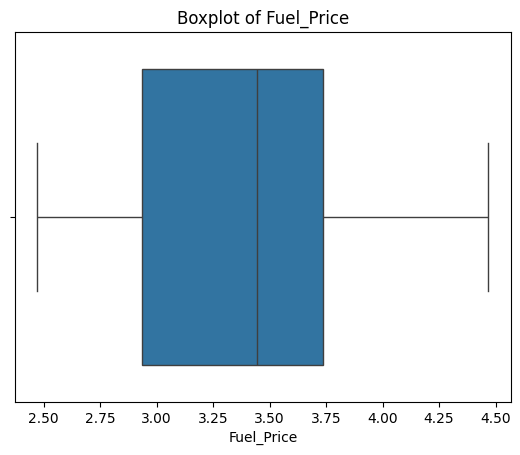

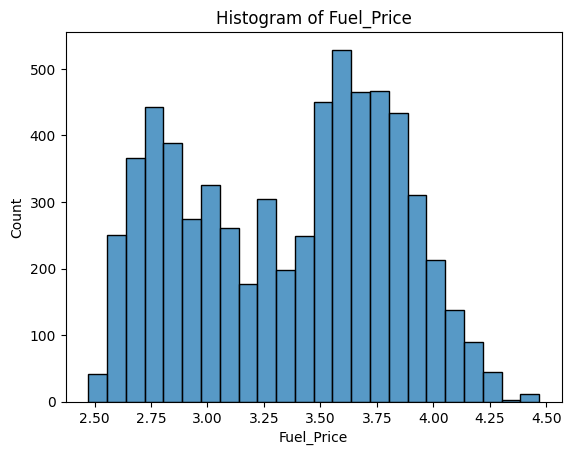

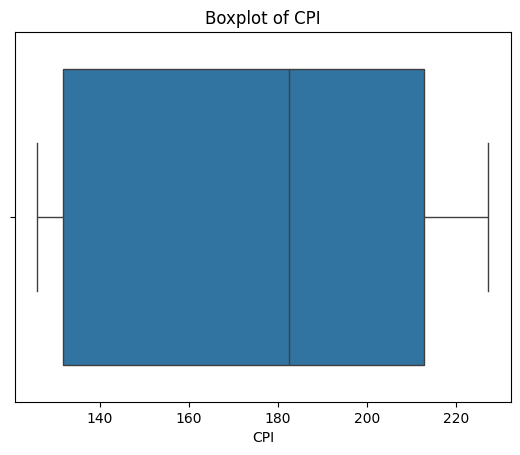

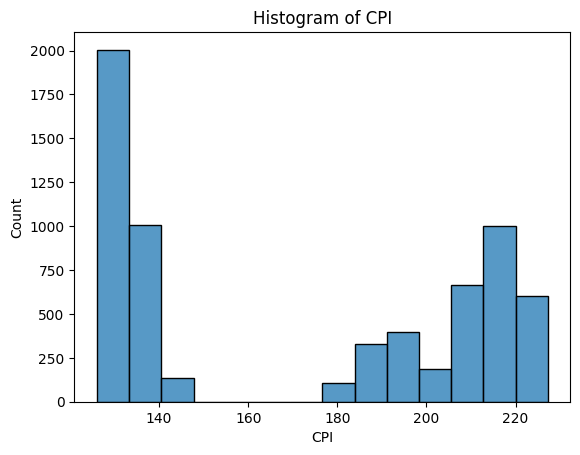

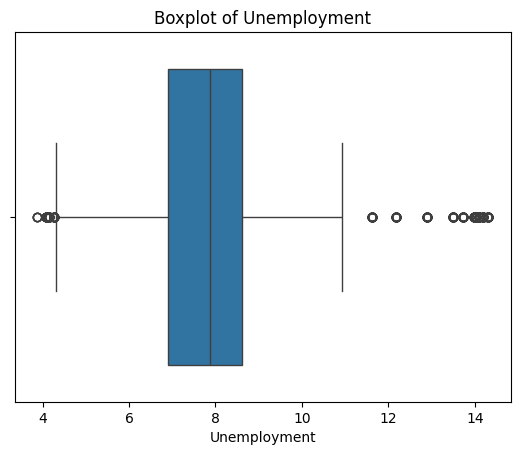

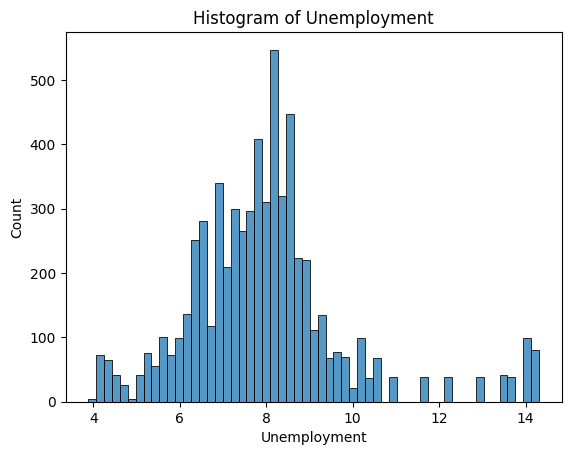

In [191]:
# Loop thru and create graphs:
for col in numerical_cols:
    numerical_var(df, col)

In [192]:
# Before we clean and feature-engineer with dates, let's understand the range...
df["Date"].value_counts(sort= "ascending")

# From a quick check, we see it ranges from 2010 to 2012 for data. Good to know.

Date
05-02-2010    45
23-12-2011    45
11-11-2011    45
18-11-2011    45
25-11-2011    45
              ..
07-01-2011    45
14-01-2011    45
21-01-2011    45
28-01-2011    45
26-10-2012    45
Name: count, Length: 143, dtype: int64

In [193]:
# Check for missing data per col
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

# Bivariate Analysis - versus Weekly Sales

In [194]:
# Remove Weekly_Sales from numerical_cols
new_var_list = numerical_cols.drop(columns = {"Weekly_Sales"}) 

In [195]:
# Graph it visually:

def bivariate_graphs(df, x_var, y_var):
    # Graph to quickly check and compare x_var vs. y_var for visual inspection...
    
    # Let's make a scatterplot:
    sns.scatterplot(data = df, x = x_var, y = y_var)
    plt.title(f"Scatterplot of {x_var} and {y_var}")
    plt.show()
    
    # Boxplot:
    sns.boxplot(data = df, x = x_var, y = y_var)
    plt.title(f"Scatterplot of {x_var} and {y_var}")
    plt.show()
    

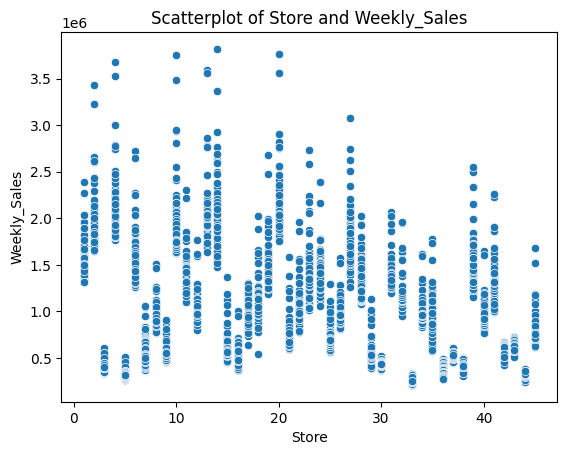

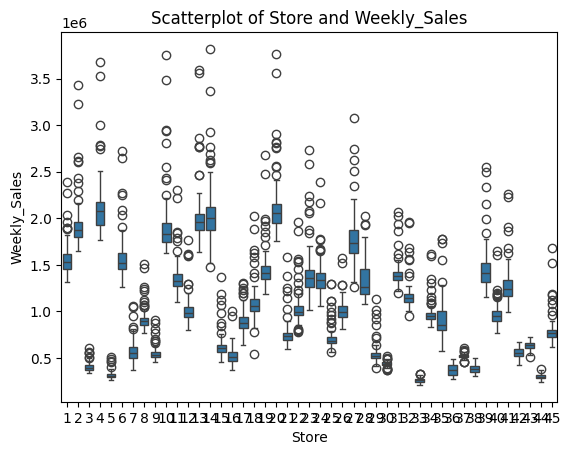

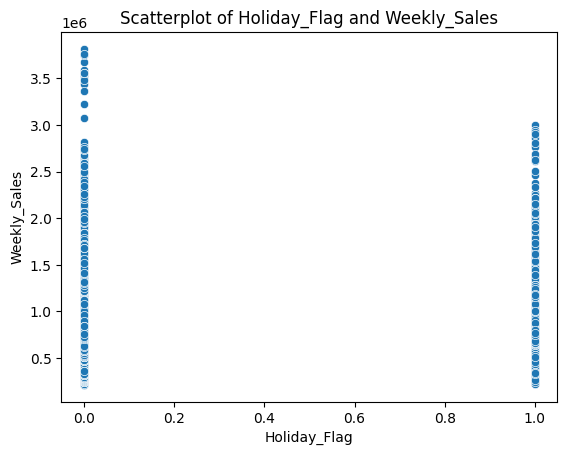

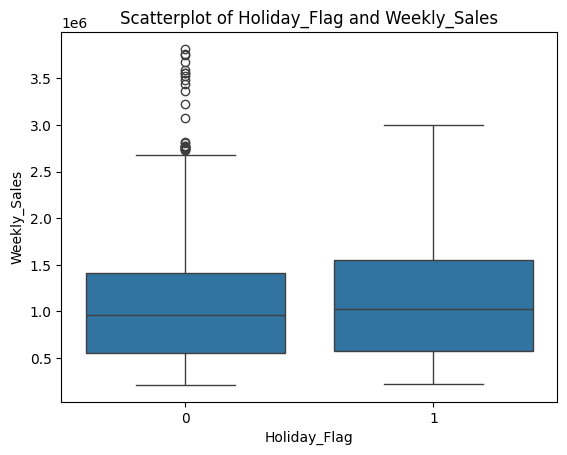

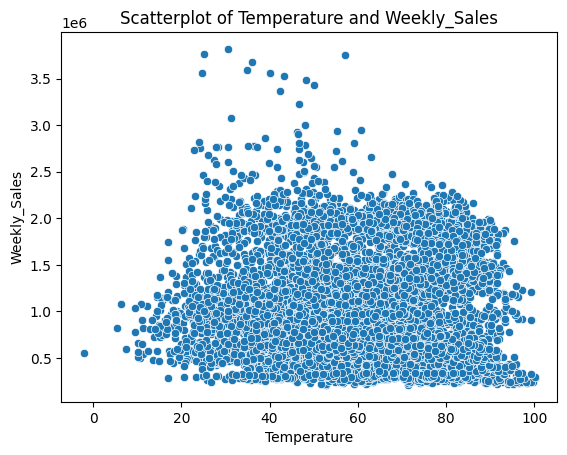

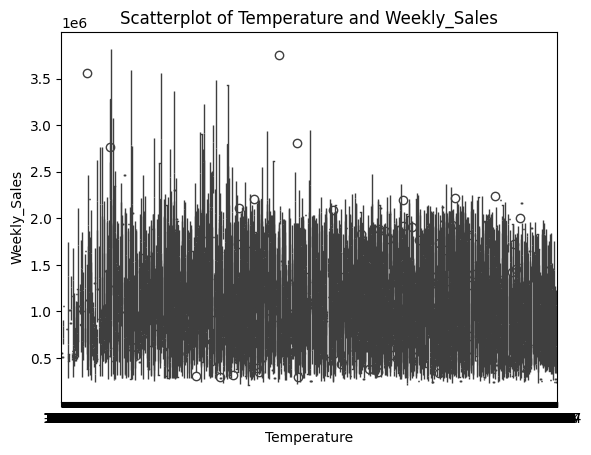

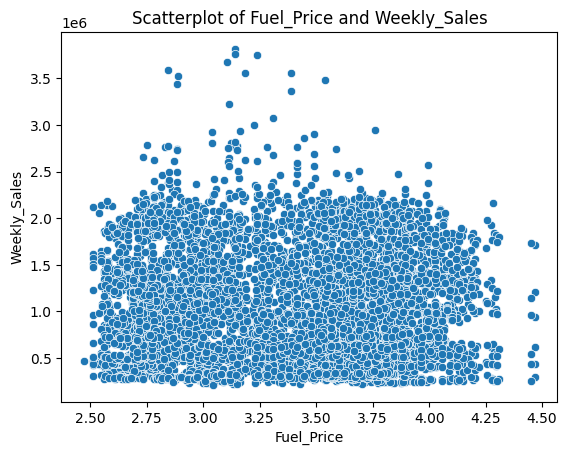

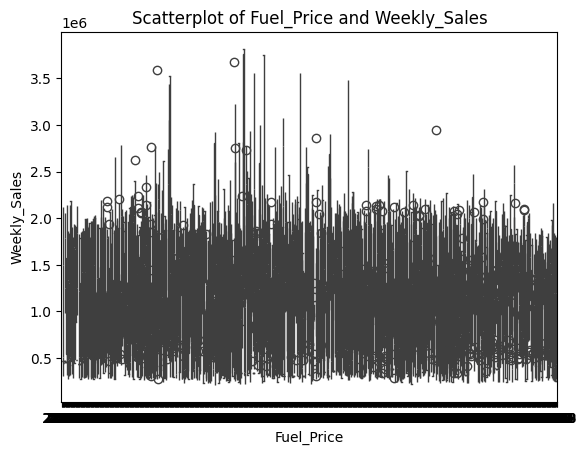

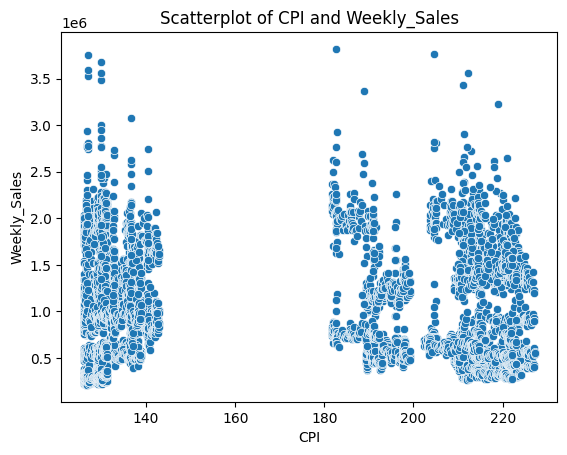

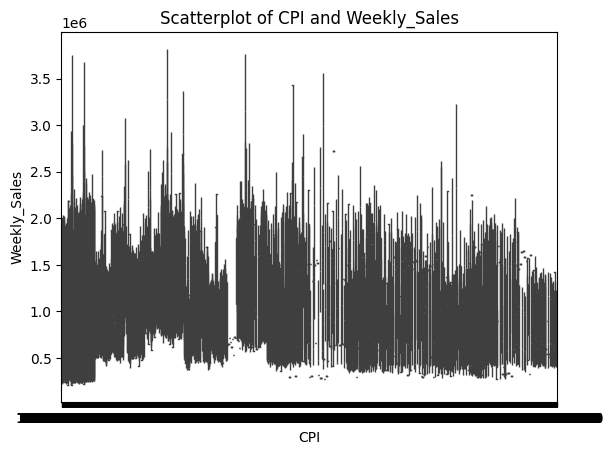

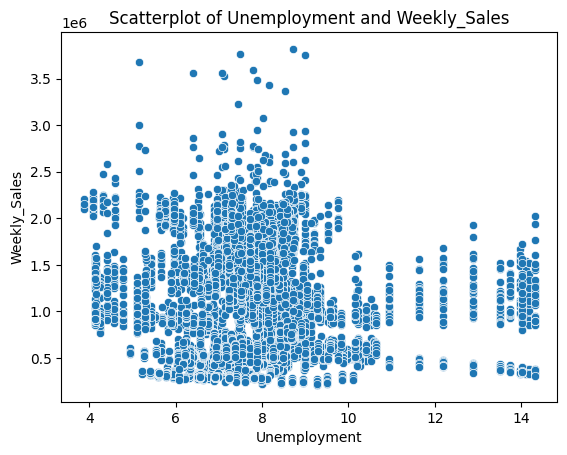

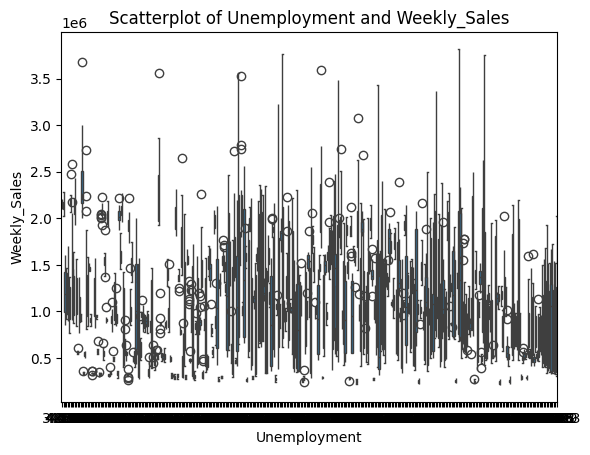

In [196]:
for var in new_var_list:
    bivariate_graphs(df, var, "Weekly_Sales")

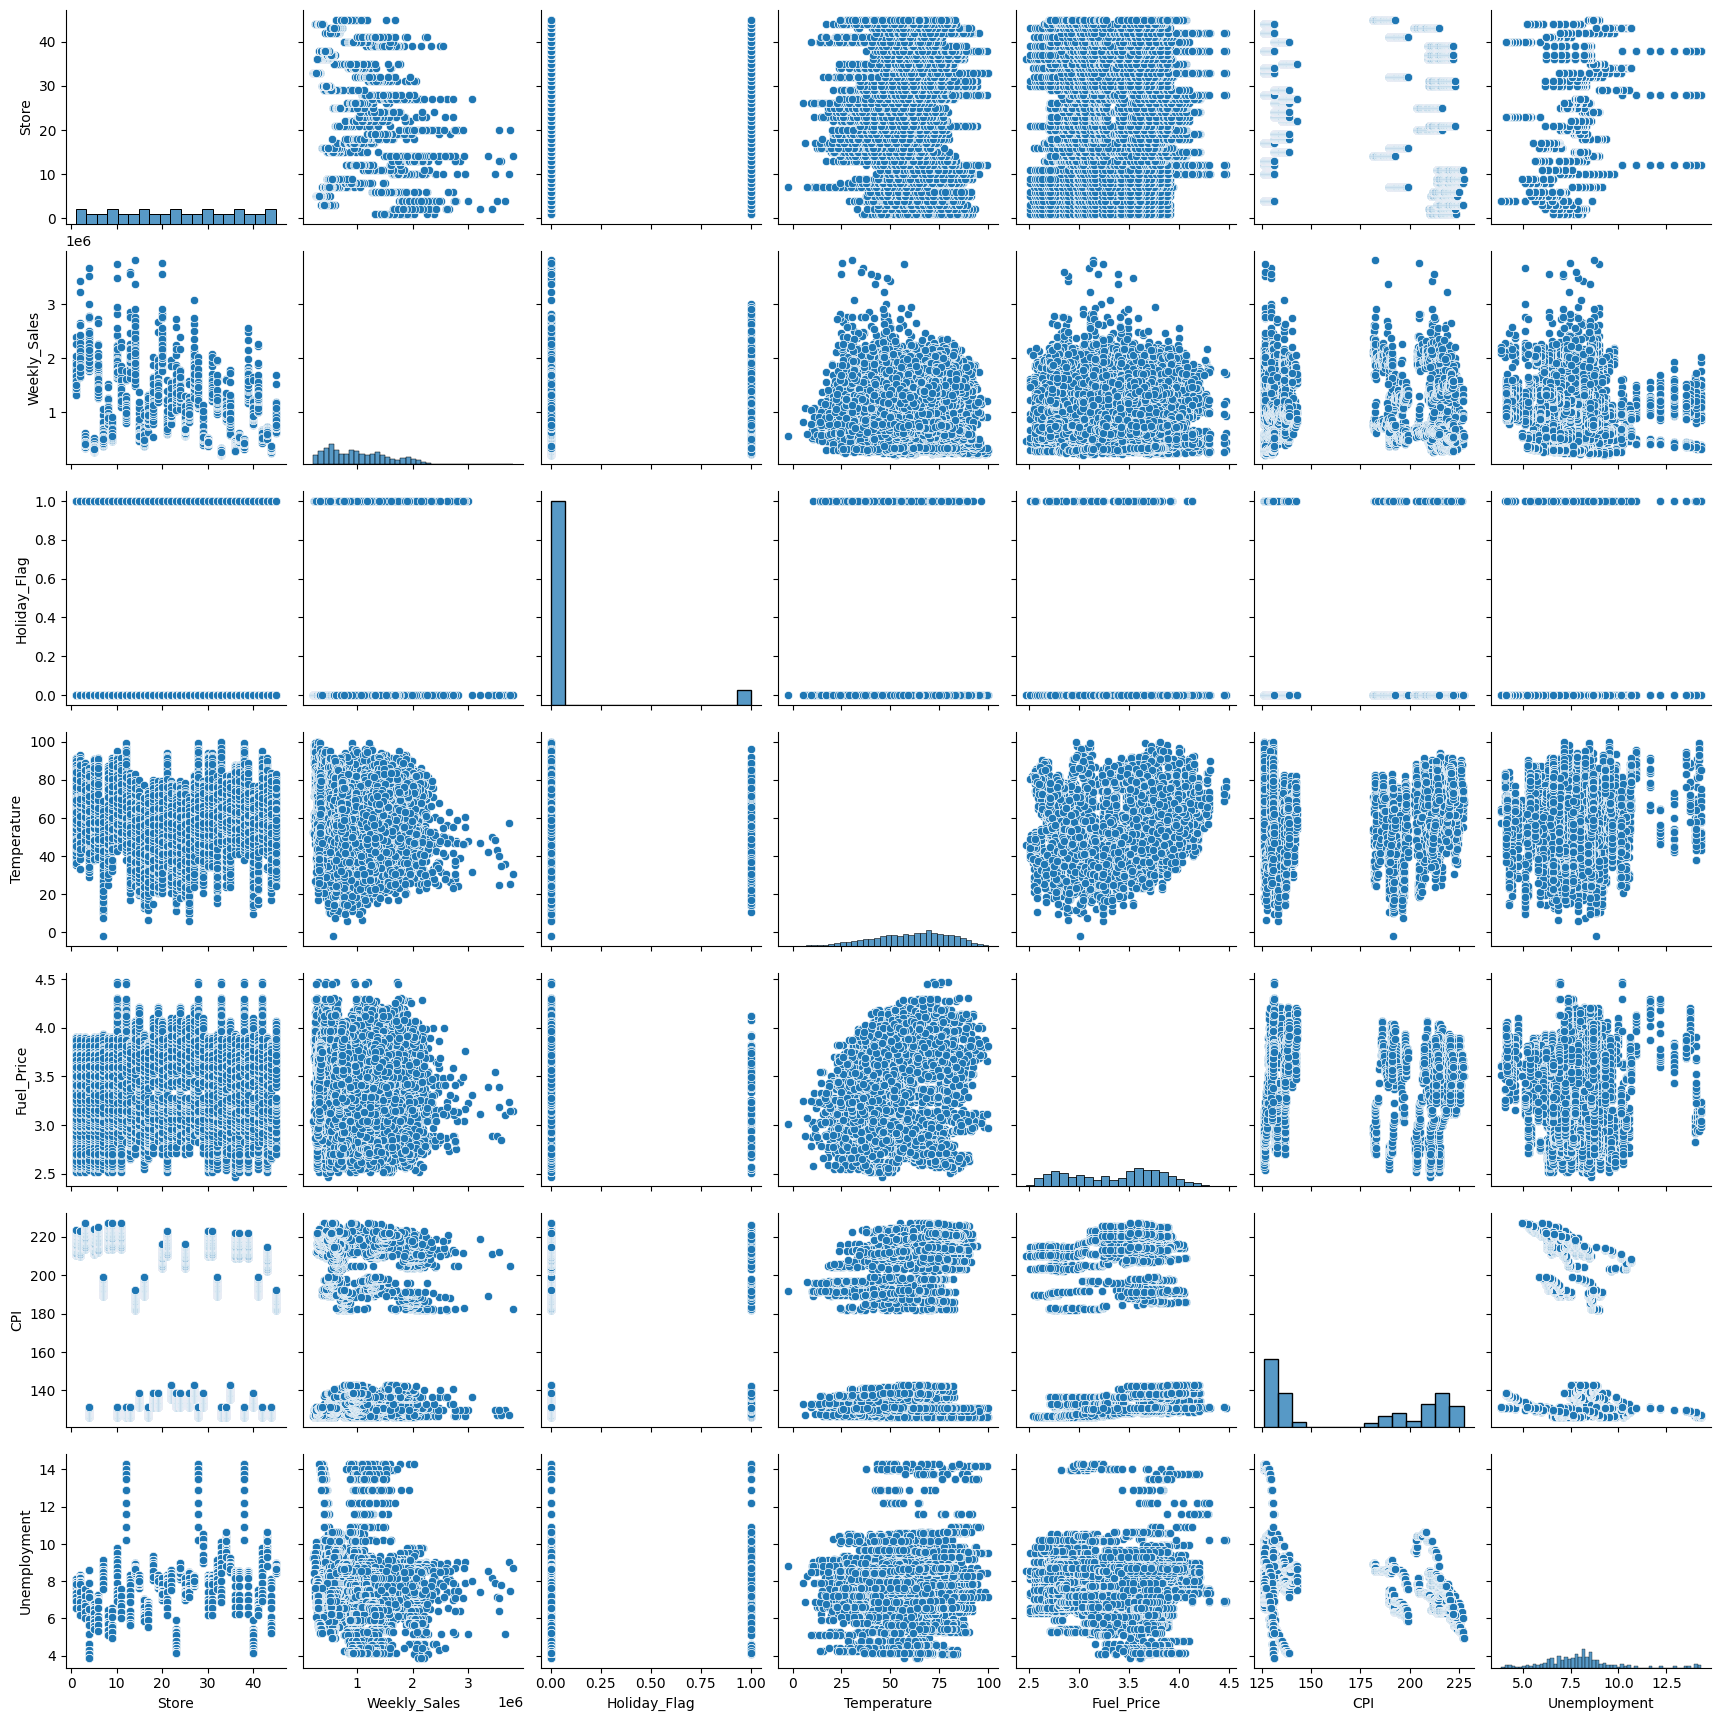

In [197]:
# Let's make one big pairplot and take a look:
sns.pairplot(data = numerical_cols)

In [198]:
# The pairplots and visuals above do not demonstrate any linear or bias-evident relationship with Weekly Sales

In [199]:
# Colinearity - since we are doing Regression, we should check for colinearity and any correlations...
numerical_cols.corr(method = "pearson")

# From above, we see from the distributions that none of them are normally distributed
# Additionally, the relationships do not appear to have a linear correlation. We can see it from the pearson results

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000e+00,-0.335332,-4.735625e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-4.735625e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000


<Axes: title={'center': 'Heatmap of Pearson R - Linear Correlations'}>

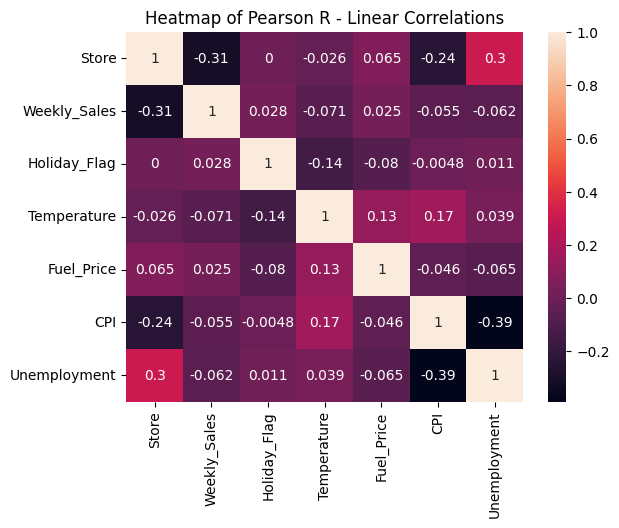

In [200]:
# Create plot
plt.title("Heatmap of Pearson R - Linear Correlations")
sns.heatmap(numerical_cols.corr(method = "spearman"), annot= True)

In [201]:
# Of all the relationships, we do see Store may be weakly correlated with Weekly Sales.
# CPI and Store, CPI and unemployment. We should check them later.

# Feature Engineering

In [202]:
# Clean up dates.
df["Date"].value_counts()

Date
05-02-2010    45
23-12-2011    45
11-11-2011    45
18-11-2011    45
25-11-2011    45
              ..
07-01-2011    45
14-01-2011    45
21-01-2011    45
28-01-2011    45
26-10-2012    45
Name: count, Length: 143, dtype: int64

In [203]:
# Convert to python datetime variable.
df["New_Date"] = pd.to_datetime(df["Date"], format = '%d-%m-%Y')

# Check, it was successful:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   object        
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   New_Date      6435 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 452.6+ KB


In [204]:
# Let's extract year, month from the data. We can also feature-engineer "quarters" from this data as well.
df["Month"] = df["New_Date"].dt.month
df["Year"] = df["New_Date"].dt.year
df["Day"] = df["New_Date"].dt.day
df['DayOfWeek'] = df["New_Date"].dt.day_name()

In [205]:
# Compare weekdays vs. weekends.
# Nevermind we cannot compare, it looks like the entire dataset is collected on Fridays...
df["Weekend_Flag"] = df["DayOfWeek"].apply(lambda x: 1 if x in ["Saturday", "Sunday"] else 0)

In [206]:
df["DayOfWeek"].value_counts()
df["Weekend_Flag"].value_counts()

Weekend_Flag
0    6435
Name: count, dtype: int64

# Holiday Analysis

* Getting inspiration, let's look at any holiday bumps or effects. Let's also look at "low" weeks.
* From my experience in CPG, shorter retail weeks may or may not have effects on sales as well, and we need to factor this later on in seasonality. (i.e. weeks where stores have less hours for example, or less supply from vendors/suppliers)

<Axes: title={'center': 'Holidays vs. Weekly_Sales'}, xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

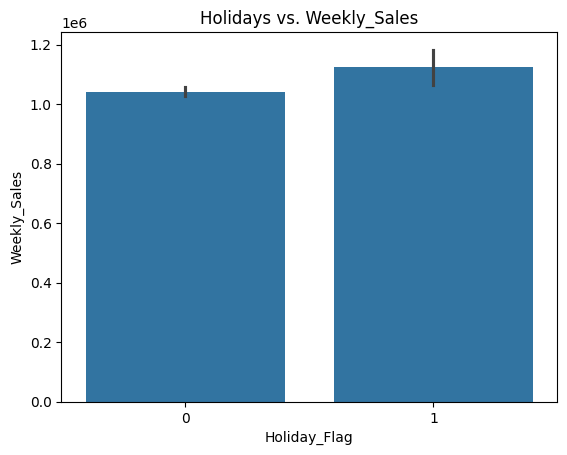

In [207]:
# Holiday Flag vs. Weekly Sales
plt.title("Holidays vs. Weekly_Sales")
sns.barplot(data = df, x ="Holiday_Flag", y = "Weekly_Sales")

<Axes: title={'center': 'Year vs. Weekly_Sales'}, xlabel='Year', ylabel='Weekly_Sales'>

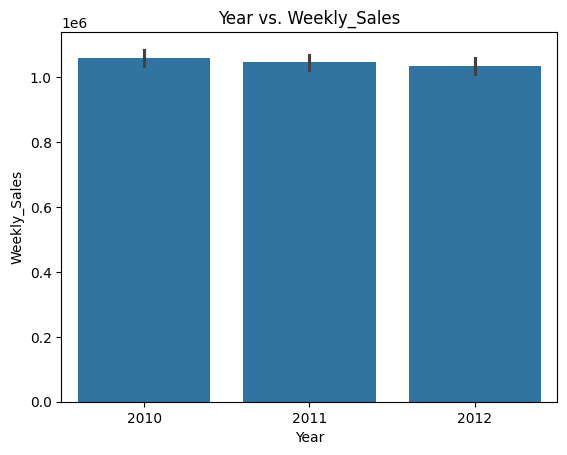

In [208]:
# Let's look at year...
# Holiday Flag vs. Weekly Sales
plt.title("Year vs. Weekly_Sales")
sns.barplot(data = df, x ="Year", y = "Weekly_Sales")

<Axes: title={'center': 'Year vs. Weekly_Sales'}, xlabel='Month', ylabel='Weekly_Sales'>

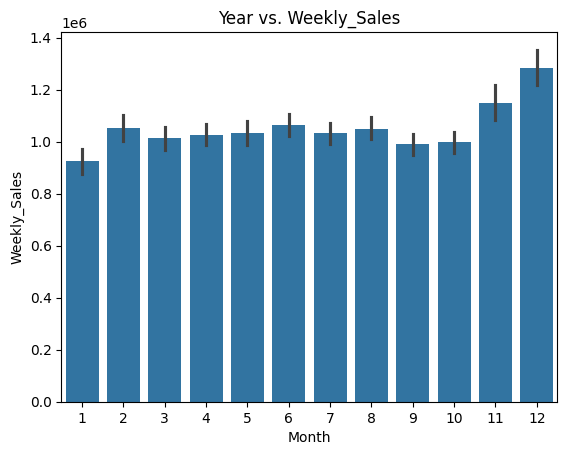

In [209]:
# Let's look at year...
# Holiday Flag vs. Weekly Sales
plt.title("Year vs. Weekly_Sales")
sns.barplot(data = df, x ="Month", y = "Weekly_Sales")

# We see signs of seasonality, which makes sense given Christmas is the hottest time for shopping.

In [210]:
# We do see a bump, an evident one. Let's start looking at time-series analysis.
# Some major USA holidays - New Years, Christmas, 4th of July, Memorial Day, American Thanksgiving

# Time Series Analysis - Walmart Data

In [211]:
# Set index as "Date":
df2 = pd.read_csv('https://raw.githubusercontent.com/TangoMango223/walmart_analysis/master/Walmart.csv')

In [212]:
# Quick conversion of Python datetime var:

# Example: If your date column is named 'Date' and in YYYYMMDD format
df2['Date'] = pd.to_datetime(df2['Date'].astype(str), format= '%d-%m-%Y')

# # Now set it as the index
df2.set_index('Date', inplace=True)

# # Display the first few rows to confirm the conversion
# print(df2.head())

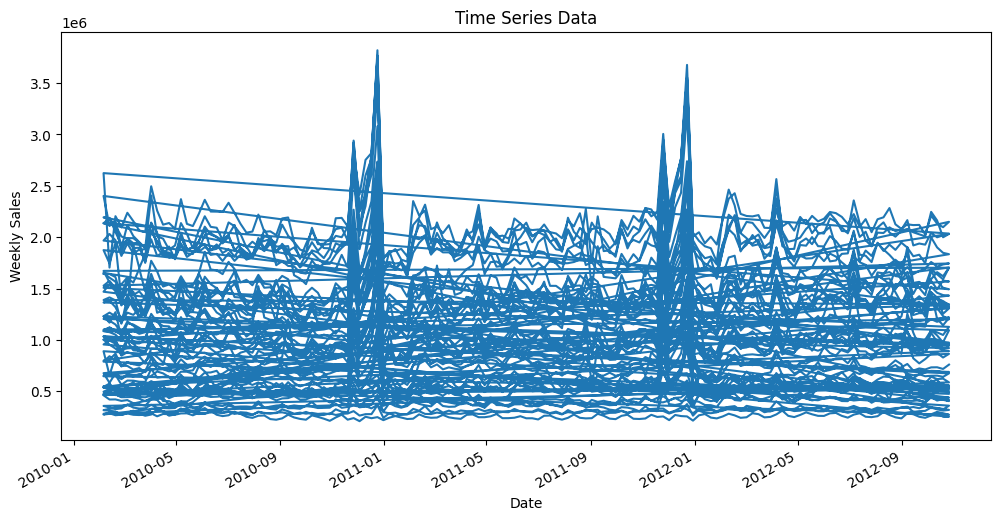

In [213]:
# Quick visual to look at it:
# Plot the time-series data
df2['Weekly_Sales'].plot(figsize=(12, 6))
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


/var/folders/vv/54f2s9796xj4fpznwy0p3f_c0000gn/T/ipykernel_88847/262856595.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df2["Weekly_Sales"].resample('M').mean()


<Axes: title={'center': 'Monthly Average Sales - Walmart'}, xlabel='Date'>

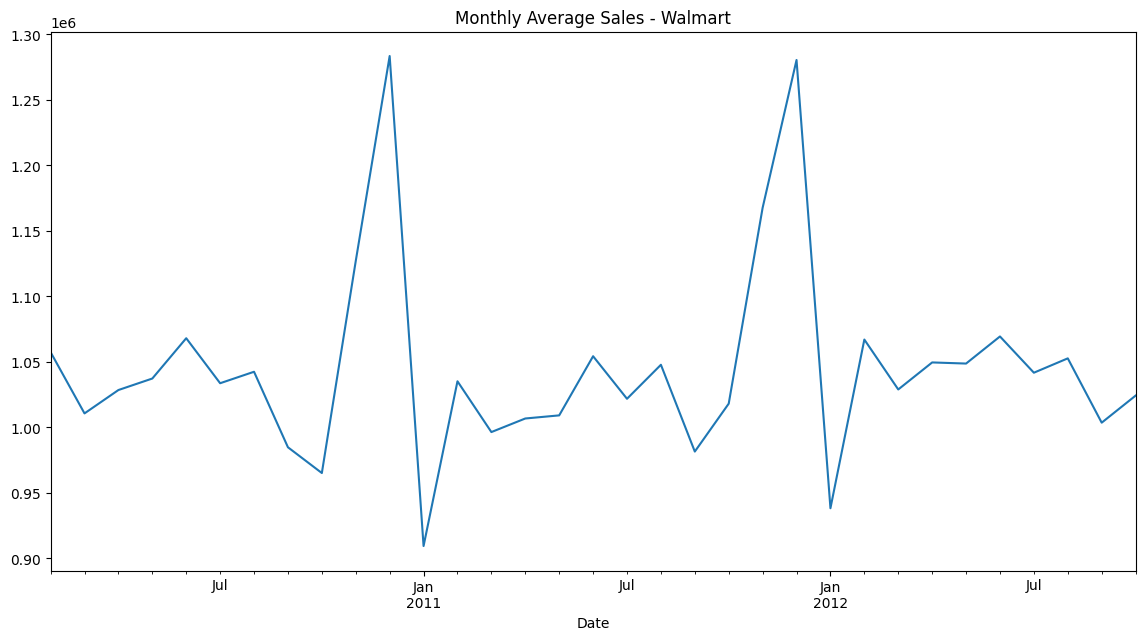

In [214]:
# Resample Data to monthly and mean sales
df_resampled = df2["Weekly_Sales"].resample('M').mean()
plt.title("Monthly Average Sales - Walmart")
df_resampled.plot(figsize = (14,7))

In [215]:
# We are already beginning to see some seasonality, such as near December Christmas and the beginning of the year is lower for Sales.
# This makes sense since January is usually historically lower.

In [216]:
# Let's test for stationary assumption:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df2['Weekly_Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# We see p-value is less than 0.05, so the data is stationary which is good.
# Why is this important? - Nature of the data for time-series is assumed to not change over time...
# Forecasting is easier with this property - we need this later for ARIMA.
# Finally, constant mean, constant variance, auto covariance

ADF Statistic: -4.624149498578303
p-value: 0.00011655869699901243


In [217]:
# Create lag features
df2['Lag_1'] = df2['Weekly_Sales'].shift(10)
df2['Lag_2'] = df2['Weekly_Sales'].shift(30)
df2['Lag_3'] = df2['Weekly_Sales'].shift(60)

# Create rolling mean features - 30 days
df2['Rolling_mean_3'] = df2['Weekly_Sales'].rolling(window=30).mean()

# # Drop any NaN values created by lagging/rolling
# df2.dropna(inplace=True)

# Display the first few rows
df2.head(120)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Lag_1,Lag_2,Lag_3,Rolling_mean_3
Date,,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,NaN,NaN,NaN,NaN
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,NaN,NaN,NaN,NaN
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,NaN,NaN,NaN,NaN
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,NaN,NaN,NaN,NaN
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2012-04-20,1,1521577.87,0,66.76,3.877,221.564074,7.143,1802477.43,1380020.27,1456800.28,1.637684e+06
2012-04-27,1,1468928.37,0,67.23,3.814,221.617937,7.143,1819870.00,1394561.83,1636263.41,1.640162e+06
2012-05-04,1,1684519.99,0,75.55,3.749,221.671800,7.143,1539387.83,1630989.95,1553191.63,1.641947e+06


# Regression Modelling - Weekly Sales Prediction

In [218]:
# STEP 1 - Define features and target variable
X = df2[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_mean_3',"Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]]
y = df2['Weekly_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [219]:
# In this scenario, there are no categorical variables for encoding. 
# But for practice, I will ensure the preprocessor has it
numerical_columns = ['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_mean_3',"Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
categorical_columns = []

In [220]:
# We will impute the mean for the time series data.
from sklearn.impute import SimpleImputer

In [221]:
# STEP 2 - Build a Preprocessor and Pipeline:

# # Deal with the NAN and missing rows
# numerical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy= "mean", fill_value= "missing", missing_values=np.nan)),
#                                           ('scaler', MinMaxScaler())])

# # Set up preprocessor to handle numerical data
# preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numerical_transformer, numerical_columns),  # Apply numerical transformations
#             ('cat', OneHotEncoder(), categorical_columns)  # Apply categorical transformations
#         ])

# # Step 1: Simplify the pipeline to only include imputation
# simple_preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', SimpleImputer(strategy='mean'), numerical_columns)  # Only apply imputation
#     ])

# Trying to fix this stupid code:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by imputing the mean
    ('scaler', MinMaxScaler())  # Scale numerical features to the range [0, 1]
])

# Create preprocessor:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),  # Apply numerical transformations
        ('cat', OneHotEncoder(), categorical_columns)  # Apply categorical transformations
    ])

In [268]:
# Store results
initial_regression_results = []

In [269]:
# STEP 3 - Model Evaluation

def model_evaluation(model):    
    # use the pipeline
    full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)])
    
    # Fit model using pipeline, considering preprocessor
    full_pipeline.fit(X_train, y_train)

    # Make Predictions and calculate the evaluation metrics
    full_predictions = full_pipeline.predict(X_test)
    full_mse = mean_squared_error(y_test, full_predictions)
    full_rmse = np.sqrt(full_mse)
    full_r2 = r2_score(y_test, full_predictions)
    full_mae = mean_absolute_error(y_test, full_predictions)
    
    # Calculate adjusted r2
    def adjusted_r2_score(r2, n, p):
        return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    
    # Calculate adjusted R²
    n = X_test.shape[0]  # Number of samples
    p = X_test.shape[1]  # Number of predictors
    full_adjusted_r2 = adjusted_r2_score(full_r2, n, p)
    
    # Here, we use the full pipeline, not just the model
    scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    
    # Check feature importance:
    this_model = full_pipeline.named_steps["model"]

    # Extract based on model type:
    if hasattr(this_model, 'feature_importances_'):
        importance = this_model.feature_importances_
        
    elif hasattr(this_model, 'coef_'):
        importance = this_model.coef_
    else:
        # Doesn't have any
        importance = None
        
    # Combine together with features in order...
    if importance is not None:
        feature_names = numerical_columns 
        feature_importance = sorted(zip(feature_names, importance), key= lambda x: x[1], reverse = True)
        for feature, score in feature_importance:
            print(f"{feature}: {score}")

    # Return the predictions (or any other value you need)
    # Print the evaluation metrics
    print(f"{model.__class__.__name__} - RMSE: {full_rmse}, CV = {np.mean(scores)}, R2: {full_r2}, Adjusted R2: {full_adjusted_r2}, MAE: {full_mae}")
    print("----------")
    
    # Let's append to regression_results
    initial_regression_results.append({
        "Model_Name": model,
        "RMSE": full_rmse,
        "Adjusted_R2": full_adjusted_r2,
        "CrossVal_Score": np.mean(scores),
        # "Feature_Names": feature_names,
    })
    
    return model, full_mse, full_rmse, full_r2, full_mae, scores

In [270]:
# Try multiple models:
model_evaluation(LinearRegression())
model_evaluation(KNeighborsRegressor())
model_evaluation(DecisionTreeRegressor())
model_evaluation(GradientBoostingRegressor())
model_evaluation(SVR())

Rolling_mean_3: 2730851.47176524
Holiday_Flag: 61878.00530974524
Temperature: 8455.644972281914
CPI: -26150.794697321868
Unemployment: -31942.699475793917
Fuel_Price: -87513.01528589276
Lag_1: -156413.1722467616
Lag_3: -314944.9393366201
Lag_2: -1023120.1142577177
LinearRegression - RMSE: 234023.59256925443, CV = -51526631582.91423, R2: 0.8363830844065633, Adjusted R2: 0.835616529362138, MAE: 137659.40385306987
----------
KNeighborsRegressor - RMSE: 182186.26132158466, CV = -35510821302.56421, R2: 0.9008391674031226, Adjusted R2: 0.9003745929661774, MAE: 96115.08446504401
----------
Rolling_mean_3: 0.8218944246741584
Fuel_Price: 0.03994410136960103
Lag_2: 0.031538615851955894
Lag_1: 0.028071456186760164
CPI: 0.023557242744087988
Temperature: 0.023041718636582633
Lag_3: 0.01701816354752437
Unemployment: 0.012259657143490262
Holiday_Flag: 0.002674619845839282
DecisionTreeRegressor - RMSE: 230372.5236712765, CV = -55450849110.813065, R2: 0.8414485284798447, Adjusted R2: 0.8407057053441439

(SVR(),
 np.float64(342837892281.7044),
 np.float64(585523.6052301431),
 -0.024230569319379835,
 np.float64(476714.95791033265),
 array([-3.26310785e+11, -2.88319509e+11, -3.26982892e+11, -3.09681038e+11,
        -3.40723107e+11]))

In [273]:
df2.corr(method = "spearman")

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Lag_1,Lag_2,Lag_3,Rolling_mean_3
Store,1.000000,-0.309227,0.000000,-0.026392,0.064878,-0.238852,0.304139,-0.308953,-0.308269,-0.307939,-0.332369
Weekly_Sales,-0.309227,1.000000,0.027774,-0.070962,0.025471,-0.055040,-0.062354,0.889861,0.759523,0.557655,0.911165
Holiday_Flag,0.000000,0.027774,1.000000,-0.143588,-0.080111,-0.004752,0.011177,-0.002119,0.001430,-0.000100,-0.000186
Temperature,-0.026392,-0.070962,-0.143588,1.000000,0.128624,0.165957,0.038833,-0.066659,-0.032947,-0.048880,-0.062602
Fuel_Price,0.064878,0.025471,-0.080111,0.128624,1.000000,-0.045867,-0.064725,0.031114,0.022422,0.027686,0.037078
CPI,-0.238852,-0.055040,-0.004752,0.165957,-0.045867,1.000000,-0.388563,-0.044411,-0.029066,-0.005460,-0.046038
Unemployment,0.304139,-0.062354,0.011177,0.038833,-0.064725,-0.388563,1.000000,-0.066236,-0.054125,-0.029284,-0.067180
Lag_1,-0.308953,0.889861,-0.002119,-0.066659,0.031114,-0.044411,-0.066236,1.000000,0.823892,0.632435,0.956120
Lag_2,-0.308269,0.759523,0.001430,-0.032947,0.022422,-0.029066,-0.054125,0.823892,1.000000,0.759395,0.905294
Lag_3,-0.307939,0.557655,-0.000100,-0.048880,0.027686,-0.005460,-0.029284,0.632435,0.759395,1.000000,0.696092


In [271]:
new_table = pd.DataFrame(initial_regression_results)

In [272]:
new_table

,Model_Name,RMSE,Adjusted_R2,CrossVal_Score
0,LinearRegression(),234023.592569,0.835617,-5.152663e+10
1,KNeighborsRegressor(),182186.261322,0.900375,-3.551082e+10
2,DecisionTreeRegressor(),230372.523671,0.840706,-5.545085e+10
3,([DecisionTreeRegressor(criterion='friedman_ms...,195518.716819,0.885260,-3.729010e+10
4,SVR(),585523.605230,-0.029029,-3.184035e+11


In [ ]:
# We will now conduct some GridSearchCV, and we will remove SVR since it didn't perform so well.
# To avoid colinearity, let's remove  Linear Regression since it doesn't handle colinearity well.
# Let's also remove SVR()

In [280]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Impute using Simpleimputer:
imputer = SimpleImputer(strategy = "mean")

# Define X_trained_imputed
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train) , columns=X_train.columns)

# Assuming X_train is your DataFrame of predictors
X_train_VIF = pd.DataFrame()
X_train_VIF['Variable'] = X_train_imputed.columns
X_train_VIF['VIF'] = [variance_inflation_factor(X_train_imputed.values, i) for i in range(X_train_imputed.shape[1])]

In [281]:
print(X_train_VIF)

         Variable        VIF
0           Lag_1  42.360985
1           Lag_2  26.934563
2           Lag_3   9.846311
3  Rolling_mean_3  85.016092
4    Holiday_Flag   1.094684
5     Temperature  13.434602
6      Fuel_Price  28.128958
7             CPI  14.896886
8    Unemployment  14.966145


In [302]:
# Param Grids:
# Parameter Grid for some regression models to try later:
# Fixed the parameter grid. Since in the model evaluate code, we pass the name "model" for each, the grid needs to match.
param_grids = {
    'KNN Regressor': {
        'model__n_neighbors': [50, 100, 300, 600] # Up to 10% of the total rows 
    },
    'Decision Tree Regressor': {
        'model__max_depth': [None, 10, 20, 30]
    },
    'Random Forest Regressor': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30]  # Adding max_depth to prevent overfitting
    },
    'Gradient Boosting Regressor': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]  # Adding max_depth for better control over fitting
    },
}

In [352]:
# Store results
tuning_reg_results = []

In [355]:
# Function for model evaluation...
def model_evaluation_with_tuning(model, paramsgrid = None):
    
    # Set up pipeline. Necessary to also impute NAN and deal with scaling.
    pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                       ('model', model)])
    
    # Complete the GridSearchCV:
    if paramsgrid: 
        grid_search = GridSearchCV(pipeline, paramsgrid, cv = 5, scoring = "neg_mean_squared_error")
        grid_search.fit(X_train, y_train)
        # Find the best
        optimal_model = grid_search.best_estimator_
        # The best model...
        print(f"The optimal model's best estimator are: {grid_search.best_params_}")
        
    else:
        # Just do model fitting with no params
        optimal_model = pipeline
        optimal_model.fit(X_train, y_train)
        
    # Create predictions
    y_pred = optimal_model.predict(X_test)
    
    # Metrics for evaluation:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Calculated Adjusted R2 to factor in increasing variables will improve R2.
    n = X_test.shape[0]  # number of observations
    p = X_test.shape[1]  # number of predictors
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    # Conduct Cross Validation Scoring:
    cv_scores = cross_val_score(optimal_model, X, y, cv = 5, scoring = "neg_mean_squared_error")
    
    # Initialize feature_importance
    feature_importance = None
    
    # Access the model after fitting
    this_model = optimal_model.named_steps["model"]

    # Extract based on model type:
    if hasattr(this_model, 'feature_importances_'):
        importance = this_model.feature_importances_
    elif hasattr(this_model, 'coef_'):
        importance = this_model.coef_
    else:
        importance = None
        print("There is no feature importance.")

    # Combine together with features in order...
    if importance is not None:
        # Extract feature names, assuming preprocessor is handling numerical and categorical data
        feature_names = numerical_columns  # Replace with correct feature names if categorical data is present
        feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
        # for feature, score in feature_importance:
        #     print(f"{feature}: {score}")
    
    # Return the predictions (or any other value you need)
    # Print the evaluation metrics
    print(f"{model.__class__.__name__} - RMSE: {rmse}, CV = {np.mean(cv_scores)}, R2: {r2}, Adjusted R2: {adjusted_r2}, MAE: {mae}")
    print("----------")
    
    # Let's append to regression_results
    tuning_reg_results.append({
        "Model_Name": model,
        "Saved Model Obj": optimal_model,
        "RMSE": rmse,
        "Adjusted_R2": adjusted_r2,
        "CrossVal_Score": np.mean(cv_scores),
        'Best Params': grid_search.best_params_ if paramsgrid else None,
        "Feature_Importance": feature_importance,
    })    
    
    return None

In [349]:
# Colinearity - since we are doing Regression, we should check for colinearity and any correlations...
numerical_cols.corr(method = "pearson")

# From above, we see from the distributions that none of them are normally distributed
# Additionally, the relationships do not appear to have a linear correlation. We can see it from the pearson results

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000e+00,-0.335332,-4.735625e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-4.735625e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000


In [356]:
# Run the models:
model_evaluation_with_tuning(KNeighborsRegressor(), param_grids["KNN Regressor"])
model_evaluation_with_tuning(DecisionTreeRegressor(), param_grids["Decision Tree Regressor"])

# This model takes too long, I am skipping...
# model_evaluation_with_tuning(RandomForestRegressor(), param_grids["Random Forest Regressor"])

The optimal model's best estimator are: {'model__n_neighbors': 50}
There is no feature importance.
KNeighborsRegressor - RMSE: 235015.61565971066, CV = -82438238142.8966, R2: 0.8349930042421514, Adjusted R2: 0.8342199365889392, MAE: 137239.8654524081
----------
The optimal model's best estimator are: {'model__max_depth': 10}
DecisionTreeRegressor - RMSE: 215904.59728145774, CV = -164065911428.0982, R2: 0.8607379778409159, Adjusted R2: 0.8600855269302279, MAE: 111390.22541724007
----------


In [362]:
# Gradient Boosting Regressor:
model_evaluation_with_tuning(GradientBoostingRegressor(), param_grids["Gradient Boosting Regressor"])

The optimal model's best estimator are: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
GradientBoostingRegressor - RMSE: 155810.81687493992, CV = -75027284606.48099, R2: 0.9274722631174219, Adjusted R2: 0.9271324663282792, MAE: 88200.81061629586
----------


In [363]:
# Summary Table:
model_regression_tuning_table = pd.DataFrame(tuning_reg_results)

In [364]:
# Ignore the first 3 - data leakage.
model_regression_tuning_table

,Model_Name,Saved Model Obj,RMSE,Adjusted_R2,CrossVal_Score,Best Params,Feature_Importance
0,KNeighborsRegressor(),"(ColumnTransformer(transformers=[('num',\n ...",235015.615660,0.834220,-8.243824e+10,{'model__n_neighbors': 50},None
1,DecisionTreeRegressor(),"(ColumnTransformer(transformers=[('num',\n ...",215904.597281,0.860086,-1.640659e+11,{'model__max_depth': 10},"[(Rolling_mean_3, 0.8504380817329308), (Fuel_P..."
2,GradientBoostingRegressor(),"(ColumnTransformer(transformers=[('num',\n ...",155810.816875,0.927132,-7.502728e+10,"{'model__learning_rate': 0.1, 'model__max_dept...","[(Rolling_mean_3, 0.8340484557821457), (Fuel_P..."


* From above, our best model is Gradient Boosting Regressor, with an adjusted R2 and the lowest RMSE, so least amount of error.
* However, Cross-Val score is not the highest, which is Decision-Tree Regressor. 

In [378]:
# Let's look at other properties to access...
gb_regressor_feats = model_regression_tuning_table["Feature_Importance"][2]


In [380]:
# Let's put this into a 
gb_regressor_feats

[('Rolling_mean_3', np.float64(0.8340484557821457)),
 ('Fuel_Price', np.float64(0.03994762854624432)),
 ('Lag_2', np.float64(0.03314394500017752)),
 ('Lag_1', np.float64(0.026369278046341208)),
 ('Temperature', np.float64(0.018963291676468704)),
 ('CPI', np.float64(0.01851508038106349)),
 ('Lag_3', np.float64(0.01623277843693136)),
 ('Unemployment', np.float64(0.010550258718181164)),
 ('Holiday_Flag', np.float64(0.002229283412446538))]

In [387]:
# Make a table:
gb_reg_table = pd.DataFrame(gb_regressor_feats)
gb_reg_table.rename(columns={0:"Feature", 1:"Importance Score"}, inplace= True)

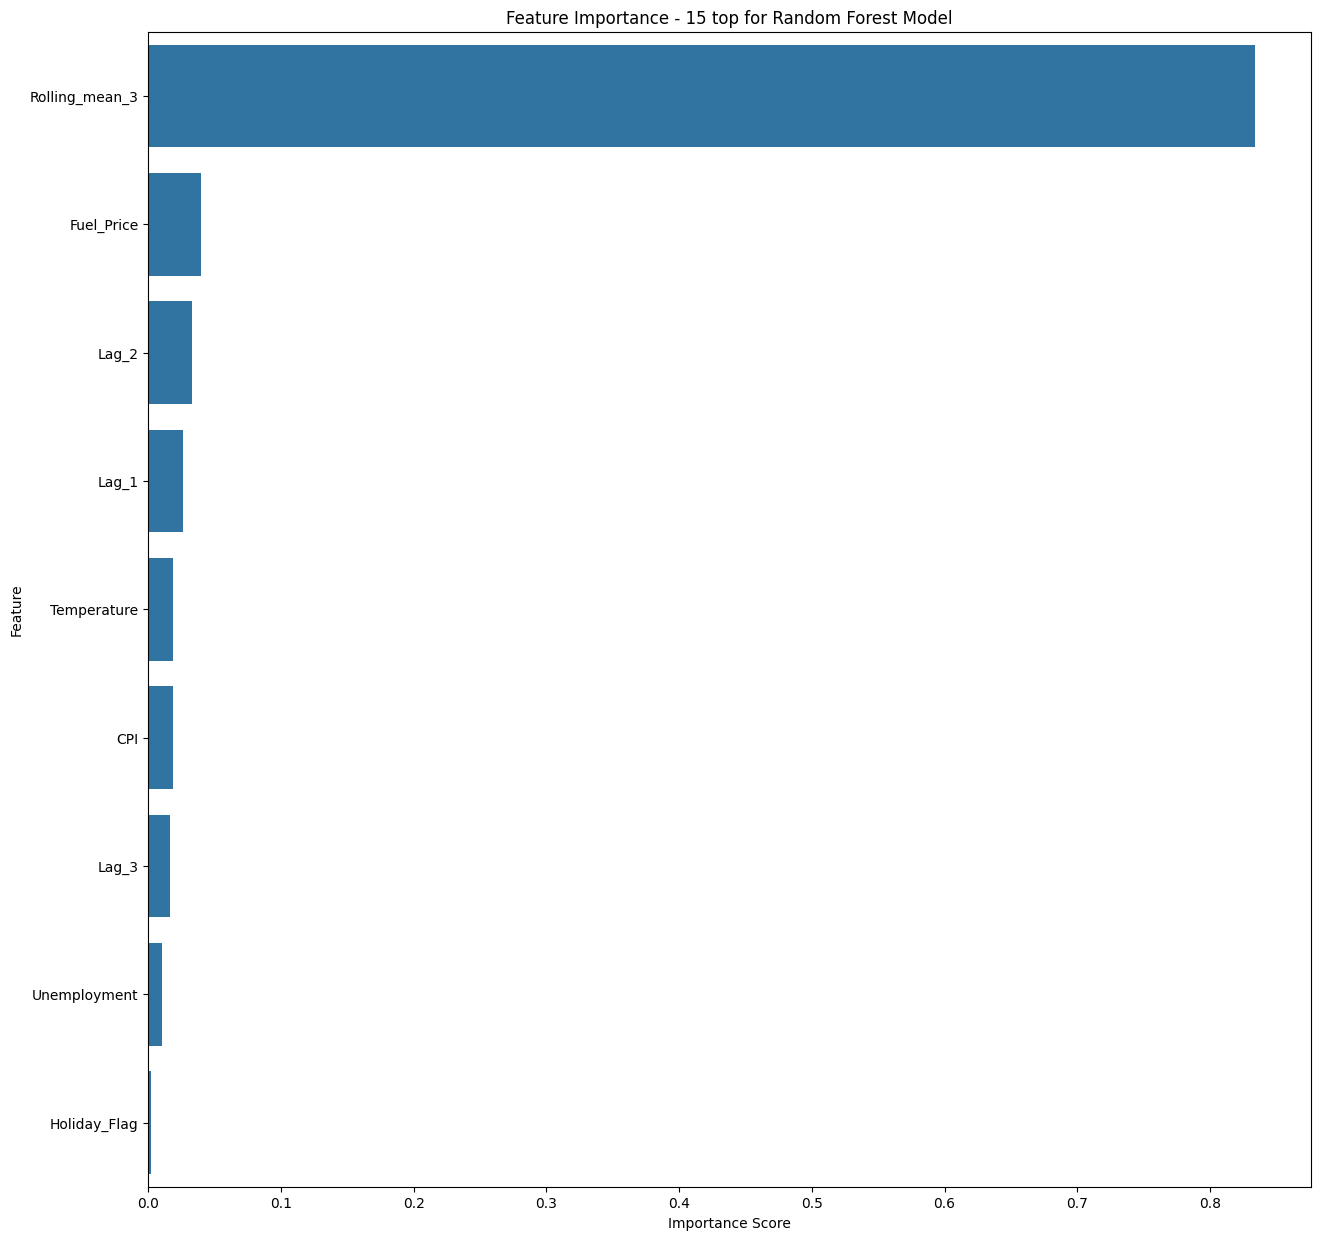

In [392]:
gb_reg_table

# Sort the DataFrame by importance
feature_importance_df = gb_reg_table.sort_values(by='Importance Score', ascending=False)

# Plot feature importance
plt.figure(figsize=(15,15))
sns.barplot(x='Importance Score', y='Feature', data=feature_importance_df)
plt.title('Feature Importance - 15 top for Random Forest Model')
plt.show()

<Axes: >

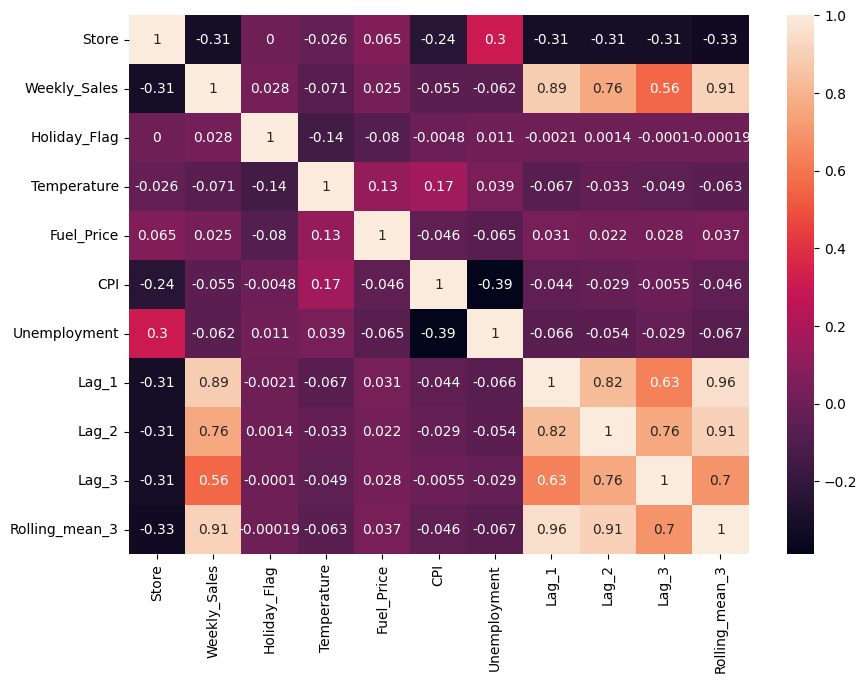

In [398]:
# Check direction of the rolling mean - 3 days that affects the model:
plt.figure(figsize = (10,7))
sns.heatmap(df2.corr(method = "spearman"), annot= True)

### Insights / What I'd do next time:

* Seek out external data pertaining to USA Walmart Sales between this time-frame, such as factors like population growth in the area near the Walmart Stores, or some product data if it exists.
* Likely remove "Rolling_Mean_3", it's far too highly correlated. While models like Gradient Boosting can handle it, I would redo with removal. 
* Overall, this is the best model, and from feature importance, we see the last 3 days sales are high indicators of weekly sales, which makes sense.
* I'd also ask Walmart Retail to collect data more on a daily basis. As seen from my EDA, all the data was collected every Friday for stores, which is not helpful. We could potentially feature_engineer looking at days of the week, like Weekday vs. Weekend.

### Feature Importance:

* Last 3 days of rolling mean sales are big indicators, which logically makes sense - if a store is doing well, you'd assume the next following days or rest of the week might do better.
* Fuel Prices have a very small positive monotonic relationship with Weekly Sales, moving together (x increases, y increases)
* Same for Lags and Temperature.

# Time-Series Specific Analysis